# Solving Inverse Problems with NNs

Inverse problems encompass a large class of practical applications in science. In general, the goal here is not to directly compute a physical field like the velocity at a future time (this is the typical scenario for a _forward_ solve), but instead more generically compute one or more parameters in the model equations such that certain constraints are fulfilled. A very common objective is to find the optimal setting for a single parameter given some constraints. E.g., this could be the global diffusion constant for an advection-diffusion model such that it fits measured data as accurately as possible. Inverse problems are encountered for any model parameter adjusted via observations, or the reconstruction of initial conditions, e.g., for particle imaging velocimetry (PIV). More complex cases aim for computing boundary geometries w.r.t. optimal conditions, e.g. to obtain a shape with minimal drag in a fluid flow.

A key aspect below will be that we're not aiming for solving only a _single instance_ of an inverse problem, but we'd like to use deep learning to solve a _larger collection_ of inverse problems. Thus, unlike the physics-informed example of {doc}`physicalloss-code` or the differentiable physics (DP) optimization of {doc}`diffphys-code-ns`, where we've solved an optimization problem for specific instances of inverse problems, we now aim for training an NN that learns to solve a larger class of inverse problems, i.e., a whole solution manifold. Nonetheless, we of course need to rely on a certain degree of similarity for these problems, otherwise there's nothing to learn (and the implied assumption of continuity in the solution manifold breaks down).

Below we will run a very challenging test case as a representative of these inverse problems: we will aim for computing a high dimensional control function that exerts forces over the full course of an incompressible fluid simulation in order to reach a desired goal state for a passively advected marker in the fluid. This means we only have very indirect constraints to be fulfilled (a single state at the end of a sequence), and a large number of degrees of freedom (the control force function is a space-time function with the same degrees of freedom as the flow field itself).

The _long-term_ nature of the control is one of the aspects which makes this a tough inverse problem: any changes to the state of the physical system can lead to large change later on in time, and hence a controller needs to anticipate how the system will behave when it is influenced. This means an NN also needs to learn how the underlying physics evolve and change, and this is exactly where the gradients from the DP training come in to guide the learning task towards solution that can reach the goal.
[[run in colab]](https://colab.research.google.com/github/tum-pbs/pbdl-book/blob/main/diffphys-code-control.ipynb)


## Formulation

With the notation from {doc}`overview-equations` this gives the minimization problem 

$$
\text{arg min}_{\theta} \sum_m \sum_i (f(x_{m,i} ; \theta)-y^*_{m,i})^2 , 
$$

where $y^*_{m,i}$ denotes the samples of the target state of the marker field, 
and $x_{m,i}$ denotes the simulated state of the marker density.
As before, the index $i$ samples our solution at different spatial locations (typically all grid cells), while the index $m$ here indicates a large collection of different target states.


Our goal is to train two networks $\mathrm{OP}$ and $\mathrm{CFE}$ with weights
$\theta_{\mathrm{OP}}$ and $\theta_{\mathrm{CFE}}$ such that a sequence 

$$
\newcommand{\pde}{\mathcal{P}}
\newcommand{\net}{\mathrm{CFE}}
\mathbf{u}_{n},d_{n} = \pde(\net(~\pde(\net(\cdots \pde(\net( \mathbf{u}_0,d_0, d_{OP} ))\cdots)))) = (\pde~\net)^n ( \mathbf{u}_0,d_0, d_{OP} ) .
$$

minimizes the loss above. The $\mathrm{OP}$ network is a predictor that determines the state $d_{OP}$ that the action of the $\mathrm{CFE}$ should aim for, i.e., it does the longer term planning from which to determine the action. Given the target $d^*$, it computes 
$d_{OP} = \mathrm{OP}(d,d^*)= f_{\mathrm{OP}}(d,d^{*};\theta_{\mathrm{OP}})$.
The $\mathrm{CFE}$ acts additively on the velocity field by computing
$\mathbf{u} + f_{\mathrm{CFE}}(\mathbf{u},d, f_{\mathrm{OP}}(d,d^{*};\theta_{\mathrm{OP}}) ;\theta_{\mathrm{CFE}}) $, where we've used $f_{\mathrm{OP}}$ and $f_{\mathrm{CFE}}$ to denote the NN representations of $\mathrm{OP}$ and $\mathrm{CFE}$, respectively, and $d^{*}$ to denote the target density state. $\theta_{\mathrm{OP}}$ and $\theta_{\mathrm{CFE}}$ denote the corresponding network weights.

For this problem, the model PDE $\mathcal{P}$ contains a discretized version of the incompressible Navier-Stokes equations in two dimensions for a velocity $\mathbf{u}$:

$$\begin{aligned}
  \frac{\partial u_x}{\partial{t}} + \mathbf{u} \cdot \nabla u_x &= - \frac{1}{\rho} \nabla p 
  \\
  \frac{\partial u_y}{\partial{t}} + \mathbf{u} \cdot \nabla u_y &= - \frac{1}{\rho} \nabla p 
  \\
  \text{s.t.} \quad \nabla \cdot \mathbf{u} &= 0,
\end{aligned}$$

without explicit viscosity, and with an additional transport equation for the marker density $d$ given by 
$\frac{\partial d}{\partial{t}} + \mathbf{u} \cdot \nabla d = 0$.

To summarize, we have a predictor $\mathrm{OP}$ that gives us a direction, an actor $\mathrm{CFE}$ that exerts a force on a physical model $\mathcal{P}$. They all need to play hand in hand to reach a given target after $n$ iterations of the simulation. As apparent from this formulation, it's not a simple inverse problem, especially due to the fact that all three functions are non-linear. This is exactly why the gradients from the DP approach are so important. (The viewpoint above also indicates that _reinforcement learning_ is a potential option. In {doc}`reinflearn-code` we'll compare DP with these alternatives.)




---

## Control of incompressible fluids 

The next sections will walk you through all the necessary steps from data generation to network training using [Φ<sub>Flow</sub>](https://github.com/tum-pbs/PhiFlow). Due to the complexity of the control problem,
we'll start with a supervised initialization of the networks, before switching to a more accurate end-to-end training with DP.
(_Note: this example uses an older version 1.4.1 of Φ<sub>Flow</sub>._)

The code below replicates an inverse problem example (the shape transitions experiment) from [Learning to Control PDEs with Differentiable Physics](https://ge.in.tum.de/publications/2020-iclr-holl/) {cite}`holl2019pdecontrol`, further details can be found in section D.2 of the paper's [appendix](https://openreview.net/pdf?id=HyeSin4FPB).

First we need to load phiflow and check out the _PDE-Control_ git repository, which also contains some numpy arrays with initial shapes.

In [ ]:
!pip install --quiet phiflow==1.4.1

import matplotlib.pyplot as plt
from phi.flow import *

if not os.path.isdir('PDE-Control'):
  print("Cloning, PDE-Control repo, this can take a moment")
  os.system("git clone --recursive https://github.com/holl-/PDE-Control.git")
    
# now we can load the necessary phiflow libraries and helper functions
import sys; sys.path.append('PDE-Control/src')
from shape_utils import load_shapes, distribute_random_shape
from control.pde.incompressible_flow import IncompressibleFluidPDE
from control.control_training import ControlTraining
from control.sequences import StaggeredSequence, RefinedSequence


## Data generation

Before starting the training, we have to generate a data set to train with, i.e., a set of ground truth time sequences $u^*$. Due to the complexity of the training below, we'll use a staged approach that pre-trains a supervised network as a rough initialization, and then refines it to learn control looking further and further ahead into the future. (This will be realized by training specialized NNs that deal with longer and longer sequences.) 

First, let's set up a domain and basic parameters of the data generation step.

In [ ]:
domain = Domain([64, 64])  # 1D Grid resolution and physical size
step_count = 16  # how many solver steps to perform
dt = 1.0  # Time increment per solver step
example_count = 1000
batch_size = 100
data_path = 'shape-transitions'
pretrain_data_path = 'moving-squares'
shape_library = load_shapes('PDE-Control/notebooks/shapes')

The `shape_library` in the last line contains ten different shapes that we'll use to intialize a marker density with at random positions.

This is what the shapes look like:

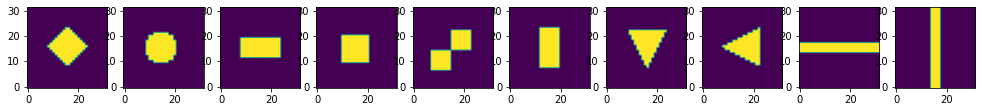

In [ ]:
import pylab
pylab.subplots(1, len(shape_library), figsize=(17, 5))
for t in range(len(shape_library)):
    pylab.subplot(1, len(shape_library), t+1)
    pylab.imshow(shape_library[t], origin='lower')


The following cell uses these shapes to create the dataset we want to train our network with.
Each example consists of a start and target (end) frame which are generated by placing a random shape from the `shape_library` somewhere within the domain.

In [ ]:
for scene in Scene.list(data_path): scene.remove()

for _ in range(example_count // batch_size):
    scene = Scene.create(data_path, count=batch_size, copy_calling_script=False)
    print(scene)
    start = distribute_random_shape(domain.resolution, batch_size, shape_library)
    end__ = distribute_random_shape(domain.resolution, batch_size, shape_library)
    [scene.write_sim_frame([start], ['density'], frame=f) for f in range(step_count)]
    scene.write_sim_frame([end__], ['density'], frame=step_count)

shape-transitions/sim_000000
shape-transitions/sim_000100
shape-transitions/sim_000200
shape-transitions/sim_000300
shape-transitions/sim_000400
shape-transitions/sim_000500
shape-transitions/sim_000600
shape-transitions/sim_000700
shape-transitions/sim_000800
shape-transitions/sim_000900


Since this dataset does not contain any intermediate frames, it does not allow for supervised pretraining. This is because to pre-train a CFE network, two consecutive frames are required while to pretrain an $\mathrm{OP}_n$ network, three frames with a distance of $n/2$ are needed.

Instead, we create a second dataset which contains these intermediate frames. This does not need to be very close to the actual dataset since it's only used for network initialization via pretraining. Here, we linearly move a rectangle around the domain.

In [ ]:
for scene in Scene.list(pretrain_data_path): scene.remove()

for scene_index in range(example_count // batch_size):
    scene = Scene.create(pretrain_data_path, count=batch_size, copy_calling_script=False)
    print(scene)
    pos0 = np.random.randint(10, 56, (batch_size, 2))  # start position
    pose = np.random.randint(10, 56, (batch_size, 2))  # end position
    size = np.random.randint(6,  10,  (batch_size, 2))
    for frame in range(step_count+1):
        time = frame / float(step_count + 1)
        pos = np.round(pos0 * (1 - time) + pose * time).astype(np.int)
        density = AABox(lower=pos-size//2, upper=pos-size//2+size).value_at(domain.center_points())
        scene.write_sim_frame([density], ['density'], frame=frame)

moving-squares/sim_000000
moving-squares/sim_000100
moving-squares/sim_000200
moving-squares/sim_000300
moving-squares/sim_000400
moving-squares/sim_000500
moving-squares/sim_000600
moving-squares/sim_000700
moving-squares/sim_000800
moving-squares/sim_000900


## Supervised initialization

First we define a split of the 1000 data samples into 100 test, 100 validation, and 800 training samples.

In [ ]:
test_range = range(100)
val_range = range(100, 200)
train_range = range(200, 1000)

The following cell trains all $\mathrm{OP}_n \,\, \forall n\in\{2,4,8,16\}$. Here the $n$ indicates the number of time steps for which the network predicts the target. In order to cover longer time horizons, we're using factors of two here to hierarchically divide the time intervals during which the physical system should be controlled.

The `ControlTraining` class is used to set up the corresponding optimization problem.
The loss for the supervised initialization is defined as the observation loss in terms of velocity at the center frame:

$$
L_o^\textrm{sup} = \left| \mathrm{OP}\Big(d_{t_i},d_{t_j}\Big) - d^*_{(t_i+t_j)/2} \right|^2 .
$$

Consequently, no sequence needs to be simulated (`sequence_class=None`) and an observation loss is required at frame $\frac n 2$ (`obs_loss_frames=[n // 2]`).
The pretrained network checkpoints are stored in `supervised_checkpoints`.

*Note: The next cell will run for some time. The PDE-Control git repo comes with a set of pre-trained networks. So if you want to focus on the evaluation, you can skip the training and load the pretrained networks instead by commenting out the training cells, and uncommenting the cells for loading below.*

In [ ]:
supervised_checkpoints = {}

for n in [2, 4, 8, 16]:
    app = ControlTraining(n, IncompressibleFluidPDE(domain, dt),
                          datapath=pretrain_data_path, val_range=val_range, train_range=train_range, trace_to_channel=lambda _: 'density',
                          obs_loss_frames=[n//2], trainable_networks=['OP%d' % n],
                          sequence_class=None).prepare()
    for i in range(1000):
        app.progress()  # Run Optimization for one batch
    supervised_checkpoints['OP%d' % n] = app.save_model()

In [ ]:
supervised_checkpoints # this is where the checkpoints end up when re-training:

{'OP16': '/root/phi/model/control-training/sim_000003/checkpoint_00001000',
 'OP2': '/root/phi/model/control-training/sim_000000/checkpoint_00001000',
 'OP4': '/root/phi/model/control-training/sim_000001/checkpoint_00001000',
 'OP8': '/root/phi/model/control-training/sim_000002/checkpoint_00001000'}

In [ ]:
# supervised_checkpoints = {'OP%d' % n: 'PDE-Control/networks/shapes/supervised/OP%d_1000' % n for n in [2, 4, 8, 16]}


This concludes the pretraining of the OP networks. These networks make it possible to at least perform a rough planning of the motions, which will be refined via end-to-end training below. However, beforehand we'll initialize the $\mathrm{CFE}$ networks such that we can perform _actions_, i.e., apply forces to the simulation. This is completely decoupled from the $\mathrm{OP}$ networks.


## CFE pretraining with differentiable physics

To pretrain the $\mathrm{CFE}$ networks, we set up a simulation with a single step of the differentiable solver.

The following cell trains the $\mathrm{CFE}$ network from scratch. If you have a pretrained network at hand, you can skip the training and load the checkpoint by running the cell after.

In [ ]:
app = ControlTraining(1, IncompressibleFluidPDE(domain, dt),
                      datapath=pretrain_data_path, val_range=val_range, train_range=train_range, trace_to_channel=lambda _: 'density',
                      obs_loss_frames=[1], trainable_networks=['CFE']).prepare()
for i in range(1000):
    app.progress()  # Run Optimization for one batch
supervised_checkpoints['CFE'] = app.save_model()

In [ ]:
# supervised_checkpoints['CFE'] = 'PDE-Control/networks/shapes/CFE/CFE_2000'

Note that we have not actually set up a simulation for the training, as the $\mathrm{CFE}$ network only infers forces between pairs of states. 


In [ ]:
# [TODO, show preview of CFE only?]

## End-to-end training with differentiable physics

Now that first versions of both network types exist, we can initiate the most important step of the setup at hand: the coupled end-to-end training of both networks via the differentiable fluid solver. While the pretraining stages relied on supervised training, the next step will yield a significantly improved quality for the control. 

To initiate an end-to-end training of the $\mathrm{CFE}$ and all $\mathrm{OP}_n$ networks with the differentiable physics loss in phiflow, we create a new `ControlTraining` instance with the staggered execution scheme.

The following cell builds the computational graph with `step_count` solver steps without initializing the network weights.


In [ ]:
staggered_app = ControlTraining(step_count, IncompressibleFluidPDE(domain, dt),
                                datapath=data_path, val_range=val_range, train_range=train_range, trace_to_channel=lambda _: 'density',
                                obs_loss_frames=[step_count], trainable_networks=['CFE', 'OP2', 'OP4', 'OP8', 'OP16'],
                                sequence_class=StaggeredSequence, learning_rate=5e-4).prepare()

App created. Scene directory is /root/phi/model/control-training/sim_000005 (INFO), 2021-04-09 00:41:17,299n

Sequence class: <class 'control.sequences.StaggeredSequence'> (INFO), 2021-04-09 00:41:17,305n

Partition length 16 sequence (from 0 to 16) at frame 8
Partition length 8 sequence (from 0 to 8) at frame 4
Partition length 4 sequence (from 0 to 4) at frame 2
Partition length 2 sequence (from 0 to 2) at frame 1
Execute -> 1
Execute -> 2
Partition length 2 sequence (from 2 to 4) at frame 3
Execute -> 3
Execute -> 4
Partition length 4 sequence (from 4 to 8) at frame 6
Partition length 2 sequence (from 4 to 6) at frame 5
Execute -> 5
Execute -> 6
Partition length 2 sequence (from 6 to 8) at frame 7
Execute -> 7
Execute -> 8
Partition length 8 sequence (from 8 to 16) at frame 12
Partition length 4 sequence (from 8 to 12) at frame 10
Partition length 2 sequence (from 8 to 10) at frame 9
Execute -> 9
Execute -> 10
Partition length 2 sequence (from 10 to 12) at frame 11
Execute -> 11
Exe

The next cell initializes the networks using the supervised checkpoints and then trains all networks jointly. You can increase the number of optimization steps or execute the next cell multiple times to further increase performance.

*Note: The next cell will run for some time. Optionally, you can skip this cell and load the pretrained networks instead with code in the cell below.*

In [ ]:
staggered_app.load_checkpoints(supervised_checkpoints)
for i in range(1000):
    staggered_app.progress()  # run staggered Optimization for one batch
staggered_checkpoint = staggered_app.save_model()

In [ ]:
# staggered_checkpoint = {net: 'PDE-Control/networks/shapes/staggered/all_53750' for net in ['CFE', 'OP2', 'OP4', 'OP8', 'OP16']}
# staggered_app.load_checkpoints(staggered_checkpoint)

Now that the network is trained, we can infer some trajectories from the test set.
(This corresponds to Fig 5b and 18b of the [original paper](https://openreview.net/pdf?id=HyeSin4FPB).)

The following cell takes the first one hundred configurations, i.e. our test set as defined by `test_range`, and let's the network infer solutions for the corresponding inverse problems.

In [ ]:
states = staggered_app.infer_all_frames(test_range)

Via the index list `batches` below, you can choose to display some of the solutions. Each row shows a temporal sequence starting with the initial condition, and evolving the simulation with the NN control forces for 16 time steps. The last step, at $t=16$ should match the target shown in the image on the far right.

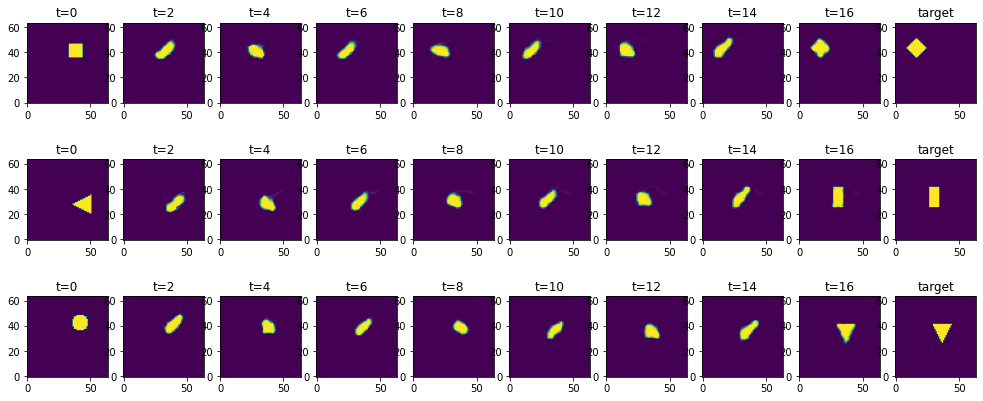

In [ ]:
batches = [0,1,2]

pylab.subplots(len(batches), 10, sharey='row', sharex='col', figsize=(14, 6))
pylab.tight_layout(w_pad=0)

# solutions
for i, batch in enumerate(batches):
    for t in range(9):
        pylab.subplot(len(batches), 10, t + 1 + i * 10)
        pylab.title('t=%d' % (t * 2))
        pylab.imshow(states[t * 2].density.data[batch, ..., 0], origin='lower')

# add targets
testset = BatchReader(Dataset.load(staggered_app.data_path,test_range), staggered_app._channel_struct)[test_range]
for i, batch in enumerate(batches):
        pylab.subplot(len(batches), 10, i * 10 + 10)
        pylab.title('target')
        pylab.imshow(testset[1][i,...,0], origin='lower')


As you can see in the two right-most columns, the network does a very good job at solving these inverse problems: the fluid marker is pushed to the right spot and deformed in the right way to match the target.

What looks fairly simple here is actually a tricky task for a neural network: 
it needs to guide a full 2D Navier-Stokes simulation over the course of 16 time integration steps. Hence, if the applied forces are slightly off or incoherent, the fluid can start swirling and moving chaotically. However, the network has learned to keep the motion together, and guide the  marker density to the target location.

Next, we quantify the achieved error rate by comparing the mean absolute error in terms of the final density configuration relative to the initial density. With the standard training setup above, the next cell should give a relative residual error of 5-6%. Vice versa, this means that more than ca. 94% of the marker density ends up in the right spot!

In [ ]:
errors = []
for batch in enumerate(test_range):
  initial = np.mean( np.abs( states[0].density.data[batch, ..., 0] - testset[1][batch,...,0] )) 
  solution = np.mean( np.abs( states[16].density.data[batch, ..., 0] - testset[1][batch,...,0] )) 
  errors.append( solution/initial )
print("Relative MAE: "+format(np.mean(errors)))

Relative MAE: 0.05450168251991272


## Next steps

For further experiments with this source code, you can, e.g.:

- Change the `test_range` indices to look at different examples, or test the generalization of the trained controller networks by using new shapes as targets.
- Try using a `RefinedSequence` (instead of a `StaggeredSequence`) to train with the prediction refinement scheme. This will yield a further improved control and reduced density error.